# Correlation with clinical outcome - TCGA

The evaluation of the merged Palma-Ikonomi models focuses on their ability to predict clinical outcomes for patients with specific mutations. Palma et al. has connected their network to three cancer hallmark phenotypes: apoptosis, differentiation and proliferation. In addition, an integrated network score was defined as subtracting the value of apoptosis and differentiation from the value of the proliferation to reflect the malignancy of the cancer. The phenotype scores were then used as a proxy of the prediction power of the model to patients’ clinical outcomes.

In [1]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

In [2]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [3]:
home = "persistent/" # home path for Logic Model Merger
model1 = biolqm.load(home + "LogicModelMerger/Models/" + model1name + ".sbml")
model2 = biolqm.load(home + "LogicModelMerger/Models/" + model2name + ".sbml")
merged_and = biolqm.load(home + "LogicModelMerger/Models/merged_and_" + model1name + "_" + model2name + ".sbml")
merged_inhibitor_wins = biolqm.load(home + "LogicModelMerger/Models/merged_inhibitor_wins_" + model1name + "_" + model2name + ".sbml")
merged_or = biolqm.load(home + "LogicModelMerger/Models/merged_or_" + model1name + "_" + model2name + ".sbml")

The evaluation of clinical outcomes prediction using the TCGA-LAML dataset is similar to the approaches that Palma et al. used in their publication.  

## Simulations of the models

As described in the paper:  
>In silico simulations were performed for different genomic profiles, including loss of function of NPM1 and/or DNMT3A and/or gain of function of FLT3. In our Boolean model simulation, oncogenes and TSG were set to fixed values of 1 and 0, respectively. Each node of the network is associated to a Boolean expression, describing how the value of the node changes depending on the activities of the upstream regulatory nodes. Nonmutated genes were considered active or inactive depending on the activities of the upstream regulatory nodes. This approach enabled to generate eight “mutation-specific” models. To estimate the level of activation of each phenotype, we assumed that the activities of the nodes directly linked to a phenotype have an additive effect on the value of the phenotype. Hence, we estimated phenotype activation by adding up the contribution of the upstream activators and subtracting that of the upstream inhibitors. Thus, a phenotype is considered “most active” whenever all activator nodes are on and inhibitors off at a steady state.  
  
Following a similar approach, we first set the fix values of the models according to the 8 mutation profiles (mutation status of FLT3, NPM1 and DNMT3A). And then run simulations using the `biolqm.fixpoints` function from `BoolNet` to compute the complete list of logical stable states (or fixpoints) of the model.   

Using the stable states, the phenotype scores can be calculated as:
- Apoptosis = tp53 - bcl2
- Differentiation =	cebpa + etv6 - meis1
- Proliferation	= myc + ccnd1 + sox4 + meis1 + stat5a
- Network = Proliferation - Differentiation - Apoptosis 

In [ ]:
# Simulate the models for each mutation profile and return the phenotype scores
def simulation(model):
    
    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0")
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["wt","flt3","npm1","dnmt3a","npm1_dnmt3a","flt3_dnmt3a","flt3_npm1","flt3_npm1_dnmt3a"]
    
    # calculate the phenotype scores
    results['APOPTOSIS'] = results['TP53'] - results['BCL2']
    results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['MYC'] + results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
    
    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    simulation_results = results.T.sort_index()
    return simulation_results


## Correlation with clinical outcomes
>We next investigated the prognostic power of our model by comparing it with additional clinical features derived from the AML TGCA dataset. Specifically, we compared the mutation-specific peripheral blood (PB) and bone marrow (BM) blast percentages with the predictions of our models.   
    
Similarly, we correlate the derived network scores with the blast percentage in peripheral blood (PB_blast) and bone marrow (BM_blast) of patients from the TCGA-LAML dataset:  
   
Mutation and clinical data are downloaded from the [NIH GDC website](https://gdc.cancer.gov/about-data/publications/laml_2012):
1. [Supplemental Table 06: All somatic mutations with annotation and readcounts from DNA and RNA sequencing](SupplementalTable06.tsv)
2. [Patient Clinical Data](https://portal.gdc.cancer.gov/files/c07a64a0-7588-4653-95ef-982b41a1a804?aeTable_offset=20)

In [4]:
# First process the mutation and clinical data

# Data file path
tsv_file_path_genes = 'https://api.gdc.cancer.gov/data/0d8851d7-1af0-4054-a527-5db763138400'
tsv_file_path_clinical = 'https://api.gdc.cancer.gov/data/1fd61a91-90d5-405a-bcef-b9df8b396a21'

# Mutation data
df_genes = pd.read_csv(tsv_file_path_genes, sep='\t', usecols=['TCGA_id', 'gene_name'])

# clinical data 
df_clinical = pd.read_csv(tsv_file_path_clinical, sep='\t', usecols=['bcr_patient_barcode', 
                                                            'lab_procedure_blast_cell_outcome_percentage_value',
                                                            'lab_procedure_bone_marrow_blast_cell_outcome_percent_value'])

# Function to determine mutation combination
def determine_combination(row):
    genes = row['gene_name']
    has_flt3 = 'FLT3' in genes
    has_npm1 = 'NPM1' in genes
    has_dnmt3a = 'DNMT3A' in genes

    if has_flt3 and has_npm1 and has_dnmt3a:
        return "flt3_npm1_dnmt3a"
    elif has_flt3 and has_dnmt3a:
        return "flt3_dnmt3a"
    elif has_flt3 and has_npm1:
        return "flt3_npm1"
    elif has_npm1 and has_dnmt3a:
        return "npm1_dnmt3a"
    elif has_flt3:
        return "flt3"
    elif has_npm1:
        return "npm1"
    elif has_dnmt3a:
        return "dnmt3a"
    else:
        return "wt"

# Group by TCGA_id and apply the combination function
grouped = df_genes.groupby('TCGA_id').agg(list).reset_index()
grouped['mutation'] = grouped.apply(determine_combination, axis=1)

# Merge the gene information with the clinical data
clinical_result = pd.merge(df_clinical, grouped[['TCGA_id', 'mutation']], left_on='bcr_patient_barcode', right_on='TCGA_id')
clinical_result = clinical_result[['TCGA_id', 'mutation', 
                   'lab_procedure_blast_cell_outcome_percentage_value',
                   'lab_procedure_bone_marrow_blast_cell_outcome_percent_value']]

# convert to numeric
clinical_result['lab_procedure_blast_cell_outcome_percentage_value'] = pd.to_numeric(clinical_result['lab_procedure_blast_cell_outcome_percentage_value'])
clinical_result['lab_procedure_bone_marrow_blast_cell_outcome_percent_value'] = pd.to_numeric(clinical_result['lab_procedure_bone_marrow_blast_cell_outcome_percent_value'])

# aggregate the mean PB of each mutation profile
clinical_aggr = clinical_result.pivot_table(
    index='mutation', 
    values=['lab_procedure_blast_cell_outcome_percentage_value','lab_procedure_bone_marrow_blast_cell_outcome_percent_value'],
    aggfunc='mean'
)
clinical_aggr.columns = ['PB_BLAST', 'BM_BLAST']

In [ ]:
# Calculate the pearson correlation between the network score and blast percentages 
def clinical_pc(simulation_results, clinical_aggr):
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    clinicals = ['PB_BLAST', 'BM_BLAST']
    
    clinical_pc_results = pd.DataFrame()
    
    for clinical in clinicals:
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        clinical_pc_results.loc[clinical, 'pc'], clinical_pc_results.loc[clinical, 'p_value'] = pearsonr(x, y)
    return clinical_pc_results

# Draw the correlation plot
def clinical_plot(simulation_results, clinical_aggr):
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    clinicals = ['PB_BLAST', 'BM_BLAST']
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, clinical in enumerate(clinicals):
        ax = axes[i]
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        pc, p_value = pearsonr(x, y)
    
        # Linear regression (best-fit line)
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{clinical} vs Network score')
        ax.set_xlabel('Network score')
        ax.set_ylabel('%' + clinical)
    
            # Annotate each data point
        for j in range(len(x)):
            label = x.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
        
        # Annotate Pearson Correlation and p-value
        ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()

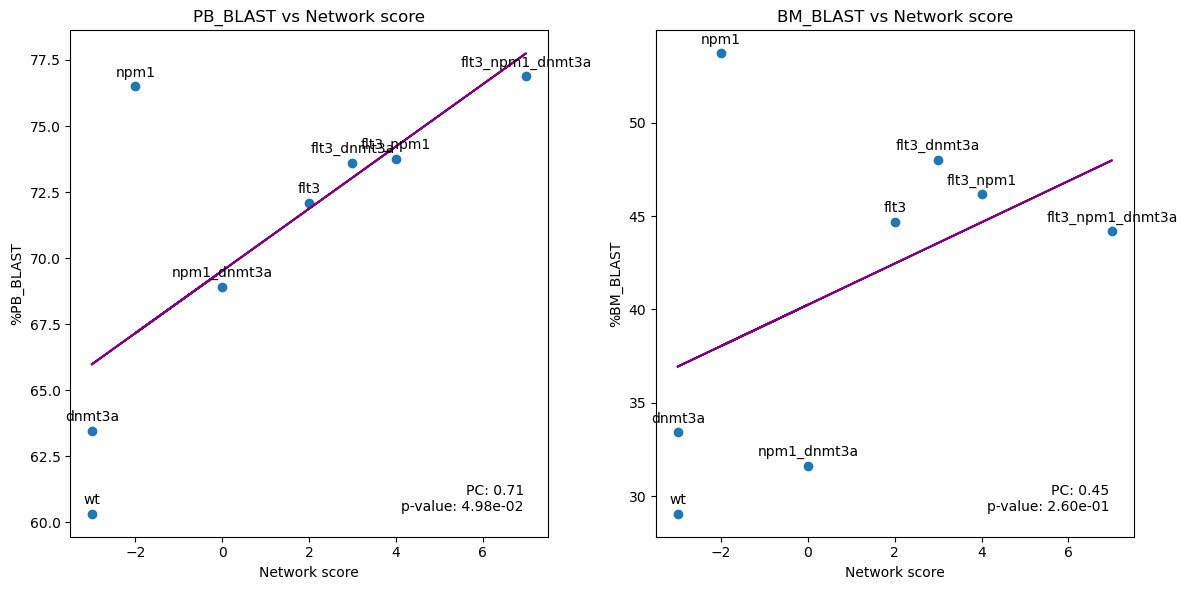

In [6]:
# Palma 2021's results
simulation_results_palma = simulation(Palma)
clinical_pc_palma = clinical_pc(simulation_results_palma, clinical_aggr)
clinical_plot(simulation_results_palma, clinical_aggr)

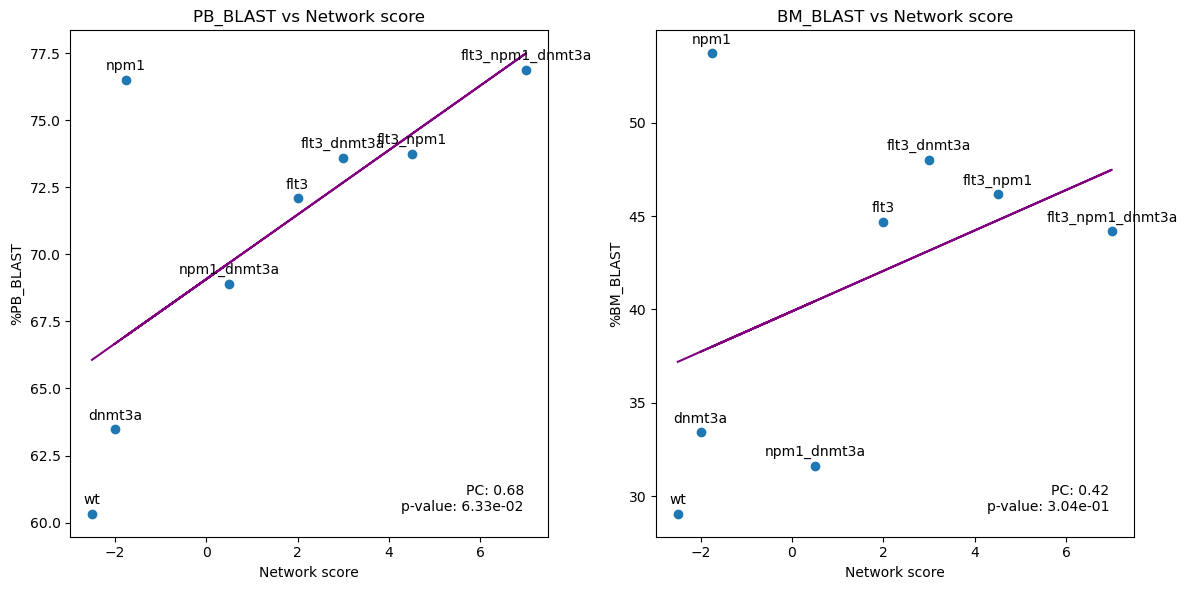

In [8]:
# Merged rules using 'OR'
simulation_results_or = simulation(merged_or)
clinical_pc_or = clinical_pc(simulation_results_or, clinical_aggr)
clinical_plot(simulation_results_or, clinical_aggr)

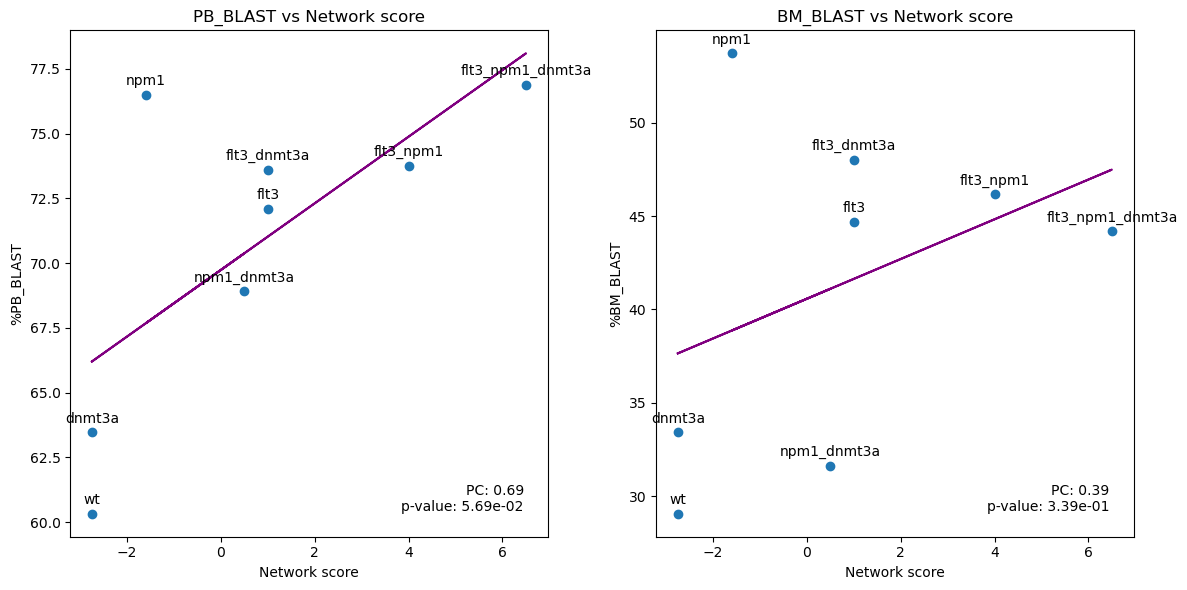

In [9]:
# Merged rules using 'Inhibitor wins'
simulation_results_inhibitor_wins = simulation(merged_inhibitor_wins)
clinical_pc_inhibitor_wins = clinical_pc(simulation_results_inhibitor_wins, clinical_aggr)
clinical_plot(simulation_results_inhibitor_wins, clinical_aggr)

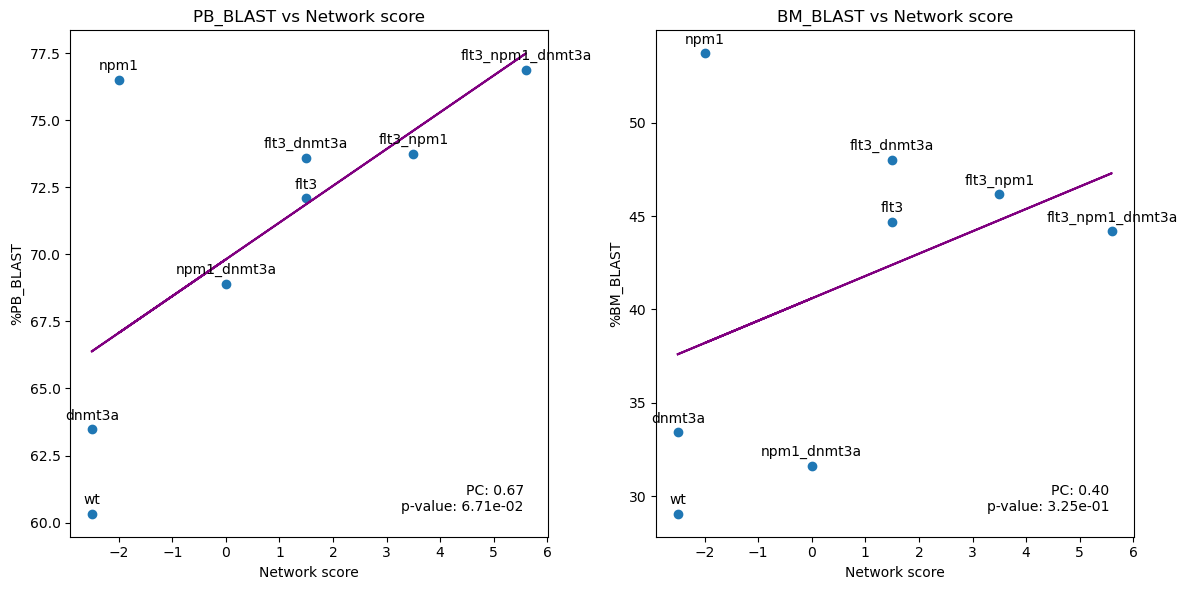

In [10]:
# Merged rules using 'AND'
simulation_results_and = simulation(merged_and)
clinical_pc_and = clinical_pc(simulation_results_and, clinical_aggr)
clinical_plot(simulation_results_and, clinical_aggr)

## Conclusion
**Merging of the Palma et al. 2021 model and Ikonomi et al. 2020 model could achieve similar performance on the prediction of blast percentages of AML patients from the TCGA-LAML dataset. The models correlate better with blast percentage in periphal blood than in bone marrow.** 
